In [97]:
import gym
import numpy as np
import matplotlib.pyplot as plt

from Layers import *
from Activations import *
from Losses import *
from Optimizers import *
from Models import *
from Metrics import *

In [98]:
# So Much Room for Activities
env = gym.make('CartPole-v1')

In [99]:
# Magic Numbers
discount_factor = .95
eps = 0.31415926535
eps_decay_factor = 0.999
num_episodes = 1000

In [100]:
# Instantiate the model
model = GraphModel()

# ### Add layers
l1 = GraphDense(20, Relu())
l3 = GraphDense(20, Relu())
l2 = GraphDense(2, Linear())
g = {
    l1: [],
    l3: [],
    l2: [l1, l3]
}
model.add(g, [l1, l3], [l2], env.observation_space.shape[0]) 

# Set loss, optimizer and accuracy objects
model.set(
    loss=MeanSquaredError(),
    optimizer=GAdam(),
    accuracy=Accuracy_Regression()
)

# Finalize the model
model.finalize()


lengths = [0]
# Try, Try, and Try Again
for i in range(num_episodes):
    state, _ = env.reset()
    eps *= eps_decay_factor
    done = False
    length = 0
    
    states = []
    targets = []
    
    # awake
    while not done:
        length += 1
        
        states.append(state)
        
        if np.random.random() < eps:
            action = env.action_space.sample()
        else:
            action = np.argmax(model.predict(state.reshape(-1, 4))[0,0])
            
        new_state, reward, done, _, __ = env.step(action)
        if done or abs(new_state[2]) > abs(state[2]):
            reward = -1
        else:
            reward = 1
        
        target = reward + discount_factor * np.max(model.predict(new_state.reshape(-1, 4)))
        target_vector = model.predict(state.reshape(-1, 4))
        target_vector[0, 0, action] = target
        
        targets.append(target_vector[0, 0])
        
        state = new_state
        
    lengths.append(length)
    
    # sleep
    model.train(np.array(states).reshape(-1, len(states), len(states[0])),
                np.array(targets).reshape(-1, len(targets), len(targets[0])), 
                epochs=3, 
                batch_size=128,
                time_series=True,
                print_every=10)

## Side Quest Time
#### reduce the number of model predictions to once per loop

In [101]:
lengths = [0]
# Try, Try, and Try Again
for i in range(num_episodes):
    state, _ = env.reset()
    eps *= eps_decay_factor
    done = False
    length = 0
    
    states = []
    targets = []
    
    action_value_prediction = model.predict(state.reshape(-1, 4))[0, 0]
    
    # awake
    while not done and length < 10000:
        length += 1
        
        states.append(state)    
        
        if np.random.random() < eps:
            action = env.action_space.sample()
        else:
            action = np.argmax(action_value_prediction)
            
        new_state, reward, done, _, __ = env.step(action)
        if done or abs(new_state[2]) > abs(state[2]):
            reward = -1
        else:
            reward = 1
        
        prev_action_value_prediction = action_value_prediction
        action_value_prediction = model.predict(new_state.reshape(-1, 4))[0, 0]
        
        target = reward + discount_factor * np.max(action_value_prediction)
        target_vector = prev_action_value_prediction
        target_vector[action] = target
        
        targets.append(target_vector)
        
        state = new_state
        
    lengths.append(length)
    
    # sleep
    model.train(np.array(states).reshape(-1, len(states), len(states[0])),
                np.array(targets).reshape(-1, len(targets), len(targets[0])), 
                epochs=3, 
                batch_size=128,
                time_series=True,
                print_every=10)

In [102]:
env.close()

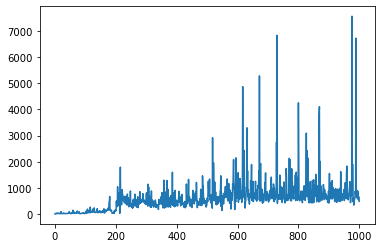

In [103]:
plt.plot(lengths)

In [104]:
windows = np.lib.stride_tricks.sliding_window_view(lengths, 50)
moving_average = windows.mean(axis=-1)

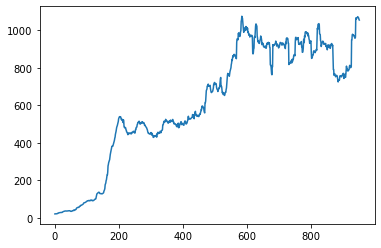

In [105]:
plt.plot(moving_average)